<a href="https://colab.research.google.com/github/elijahveto/pennystocks/blob/main/pennystock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Questions**



*   Are any of the signals observed indicative of a good performance (good defined as strictly positive returns on average)? 
*   Is there a difference in the performance of indicators pre and post Tech-Sector crash (due to 10y yield increase)? 
*   Do more signals per Ticker indicate a better performance? 
*   Is there a correlation between price and performance?







**< general info on dataset >** 

*   contains data collected from the 8th of Jan 2021 - 16th of March 2021 
*   sources used: Stockwits, Finviz, Tradingview
*   data collected on stocks trading at $10 or below at time of collection
*   performance was tracked at t1 (post 1 day), t2 and t7
*   data will be seperated in pre-crash and post-crash (dated to 15th of February), hence nearly fairly eqaully split







In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format

# Data cleanup and preparation

In [252]:
crash = pd.to_datetime('2021-02-15')

In [306]:
data = pd.read_csv('penny_summary.csv')

In [307]:
data.Signal = data.Signal.str.strip()
data = data.query('Signal != "(Deadnsyde)"')
data.Log_Price_Closing_Price_t0 = data.Closing_Price_t0.where(data.Signal == '(Tradingview Scanner) pennies', data.Log_Price_Closing_Price_t0)

In [308]:
data.Log_Date_t0 = pd.to_datetime(data.Log_Date_t0)

In [311]:
for i in ['Log_Price_Closing_Price_t0', 'Closing_Price_t1', 'Closing_Price_t2', 'Closing_Price_t7', 'Closing_Price_t0', 'Absolute_Change']: 
  for j in ['no data', 'None', 'nan']:
    data[i] = data[i].astype(str).str.replace(j, '')
  data[i] = data[i].astype(str).str.replace(',', '.')
  data[i] = pd.to_numeric(data[i])

In [312]:
data['Absolute_Change'] = data.apply(lambda row: float(row['Closing_Price_t7'])/float(row['Log_Price_Closing_Price_t0']) if pd.isna(row['Absolute_Change']) and not pd.isna(row['Closing_Price_t7'])
                                                       else
                                                        (float(row['Closing_Price_t2'])/float(row['Log_Price_Closing_Price_t0']) if not pd.isna(row['Closing_Price_t2']) 
                                                        else
                                                       (float(row['Closing_Price_t1'])/float(row['Log_Price_Closing_Price_t0']) if not pd.isna(row['Closing_Price_t1']) 
                                                        else
                                                        (float(row['Closing_Price_t0'])/float(row['Log_Price_Closing_Price_t0']) if not pd.isna(row['Closing_Price_t0']) 
                                                         else row['Absolute_Change']))),axis=1)
data['Absolute_Change'] = data.apply(lambda row: round(float(row['Absolute_Change']),2) if not pd.isna(row['Absolute_Change']) else row['Absolute_Change'], axis=1)

data['Change_t7'] = data.apply(lambda row: round(float(row['Closing_Price_t7']) / float(row['Log_Price_Closing_Price_t0']), 2) if pd.isna(row['Change_t7']) and not pd.isna(row['Closing_Price_t7']) else row['Change_t7'], axis=1)
data['Change_t2'] = data.apply(lambda row: round(float(row['Closing_Price_t2'])/float(row['Log_Price_Closing_Price_t0']),2) if  pd.isna(row['Change_t2']) and not pd.isna(row['Closing_Price_t2']) else row['Change_t2'], axis=1)
data['Change_t1'] = data.apply(lambda row: round(float(row['Closing_Price_t1']) / float(row['Log_Price_Closing_Price_t0']),2) if pd.isna(row['Change_t1']) and not pd.isna(row['Closing_Price_t1']) else row['Change_t1'], axis=1)
data['Change_t0'] = data.apply(lambda row: round(float(row['Closing_Price_t0']) / float(row['Log_Price_Closing_Price_t0']), 2) if  pd.isna(row['Change_t0']) and not pd.isna(row['Closing_Price_t0']) else row['Change_t0'], axis=1)

In [313]:
print(f'dataframe length before split: {len(data)}')
before_crash = data[data.Log_Date_t0 < crash]
print(f'before crash dataframe length: {len(before_crash)}')
after_crash = data[data.Log_Date_t0 > crash]
print(f'after crash dataframe length: {len(after_crash)}')

dataframe length before split: 556
before crash dataframe length: 249
after crash dataframe length: 307


In [263]:
data.sample(1)

,Signal,Sector,Ticker,Log_Date_t0,Log_Price_Closing_Price_t0,Change_Log_Date,Description,Closing_Price_t0,Closing_Price_t1,Closing_Price_t2,Closing_Price_t7,Change_t0,Change_t1,Change_t2,Change_t7,Absolute_Change,t-_t0,Other_Signals,Total_Signals,Current_Price,High_since_Log
280,(Finviz) unusualvolume,healthcare,IDXG,2021-02-17,4.50,red,nan,4.44,4.06,4.30,3.92,0.99,0.90,0.96,0.87,0.96,27.00,unusualvolume (2021-02-17),1.00,nan,nan


The data so far is not an accurate representation of signal performance, as the signal assigned to a ticker is only the first signal that was tracked for the respective ticker. All afterwards collected signals were tracked in 'Other Signals' - see sample above. Hence a new dataset shall be created, where tickers are not unique anymore and can appear in various signal buckets. 

In [190]:
new_df = data
for index, row in data.iterrows():
  if not pd.isna(row.Other_Signals): 
    out = row.Other_Signals.split(',')
    for signal in out:
      sig = signal.split(' (')
      new_row = {
          'Signal' : sig[0].strip(), 
          'Sector': '', 
          'Ticker': row.Ticker, 
          'Log_Date_t0': sig[1].strip(')'), 
          'Log_Price_Closing_Price_t0': row.Log_Price_Closing_Price_t0, 
          'Change_Log_Date': row.Change_Log_Date, 
          'Closing_Price_t0': row.Closing_Price_t0, 
          'Closing_Price_t1': row.Closing_Price_t1, 
          'Closing_Price_t2': row.Closing_Price_t2,
          'Closing_Price_t7': row.Closing_Price_t7, 
          'Change_t0': row.Change_t0, 
          'Change_t1': row.Change_t1,
          'Change_t2': row.Change_t2, 
          'Change_t7': row.Change_t7, 
          'Absolute_Change':	row.Absolute_Change,
          't-_t0': row['t-_t0'],
          'Other_Signals': '', 
          'Total_Signals': row.Total_Signals
      }
      new = pd.DataFrame.from_records([new_row])
      new_df = new_df.append(new, ignore_index=True)

In [17]:
new_df.shape

(1984, 21)

In [264]:
new_df.drop_duplicates(inplace=True)
new_df = new_df[new_df.Signal != '']
new_df.shape

(749, 21)

In [266]:
new_df.loc[new_df.Signal == 'Special Filter', 'Signal'] = '(Finviz) Special Filter'
new_df.loc[new_df.Signal == 'latestbuys', 'Signal'] = '(Finviz) latestbuys'
new_df.loc[new_df.Signal == 'mostactive', 'Signal'] = '(Finviz) mostactive'
new_df.loc[new_df.Signal == 'unusualvolume', 'Signal'] = '(Finviz) unusualvolume'
new_df.loc[new_df.Signal == 'most-active', 'Signal'] = '(Stockwits) most-active'
new_df.loc[new_df.Signal == 'trending', 'Signal'] = '(Stockwits) trending'
new_df.loc[new_df.Signal == 'watchers', 'Signal'] = '(Stockwits) watchers'
new_df.loc[new_df.Signal == 'pennies', 'Signal'] = '(Tradingview Scanner) pennies'
new_df.loc[new_df.Signal == 'personal_screener', 'Signal'] = '(Tradingview Scanner) personal_screener'
new_df.loc[new_df.Sector == 'healthcare', 'Sector'] = 'Healthcare'
new_df.loc[new_df.Sector == 'Health Technology', 'Sector'] = 'Healthcare'
new_df.Sector.fillna('undefined', inplace=True)
new_df.Sector.dropna(inplace=True)

In [267]:
new_df.drop(columns=['Other_Signals'], inplace=True)
new_df.shape

(749, 20)

In [268]:
new_df.Log_Date_t0 = pd.to_datetime(new_df.Log_Date_t0)
new_df.drop_duplicates(subset=['Signal', 'Ticker',], inplace=True)
new_df.shape

(749, 20)

In [270]:
before_crash = new_df[new_df.Log_Date_t0 < crash]
after_crash = new_df[new_df.Log_Date_t0 > crash]

# General Dataset

In [291]:
count = new_df.groupby('Sector', as_index=False).agg({'Ticker':pd.Series.count})
count.loc[(count.Sector == ''),'Sector']='undefined'

In [295]:
px.pie(labels = count.Sector, values = count.Ticker, names = count.Sector, hole = 0.2, title = 'Data set by Sectors')

Sector distribution is unequal, as Finviz data set covers the healthcare sector only. Second to healthcare are the undefined sectors (no data was collected on sector at log date) 

In [273]:
sig = new_df.groupby('Signal').agg({'Ticker': pd.Series.count})
sig.sort_values('Ticker', ascending = True, inplace= True)
px.bar(x= sig.Ticker, y=sig.index, orientation = 'h', title='Data set by Signals' )

# Ø Performance 

In [274]:
before = before_crash.groupby('Signal').agg({'Absolute_Change': pd.Series.mean, 'Change_t1': pd.Series.mean, 'Change_t2': pd.Series.mean, 'Change_t7': pd.Series.mean, 'Ticker': pd.Series.count})
before

,Absolute_Change,Change_t1,Change_t2,Change_t7,Ticker
Signal,,,,,
(Finviz) Special Filter,1.15,1.14,1.15,1.40,3
(Finviz) latestbuys,1.05,1.06,1.05,1.04,9
(Finviz) mostactive,1.06,1.05,1.06,1.08,82
(Finviz) unusualvolume,1.03,1.03,1.03,1.03,103
(Stockwits) most-active,1.58,1.53,1.58,1.63,7
(Stockwits) trending,1.14,1.20,1.14,1.07,10
(Stockwits) watchers,1.53,1.48,1.53,1.57,9
(Tradingview Scanner) pennies,1.00,1.04,1.04,1.20,10
(Tradingview Scanner) personal_screener,1.04,1.08,1.04,1.07,82


It appears that all indicators perform very well and the performance is strictly positive. However, there is an unequal distribution between the Signals and some n(Signal) are too small, i.e. n=3 for Finviz Special Filter. Hence, it is not statistically valid yet. 

In [276]:

after = after_crash.groupby('Signal').agg({'Absolute_Change': pd.Series.mean, 'Change_t1': pd.Series.mean, 'Change_t2': pd.Series.mean, 'Change_t7': pd.Series.mean, 'Ticker': pd.Series.count})
after

,Absolute_Change,Change_t1,Change_t2,Change_t7,Ticker
Signal,,,,,
(Finviz) Special Filter,1.04,1.06,1.06,nan,3
(Finviz) latestbuys,0.97,0.97,0.96,0.94,29
(Finviz) mostactive,0.96,0.99,0.95,0.95,60
(Finviz) unusualvolume,0.97,0.98,0.96,0.91,104
(Stockwits) most-active,0.97,0.97,0.97,0.83,3
(Stockwits) trending,0.95,0.96,0.95,0.95,20
(Stockwits) watchers,1.04,1.05,1.04,0.93,25
(Tradingview Scanner) pennies,1.00,0.80,0.82,0.97,64
(Tradingview Scanner) personal_screener,0.99,0.99,0.98,0.92,126


After the market crash the performance is clearly all negative returns, yet again stockwits most active and stockwits watchers outperform the other signals. Note: the absolute change Ø is a little bit off in the after crash data set, as it is measured by the last available change for a given ticker (i.e. t7 then t2 then t1. Hence, tickers are included here that might not have reached t7 etc. yet. 

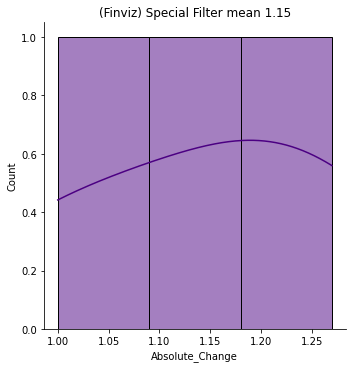

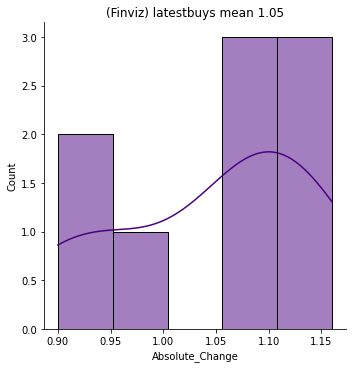

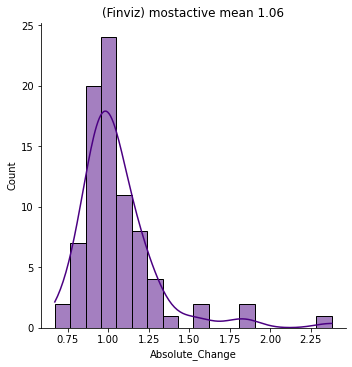

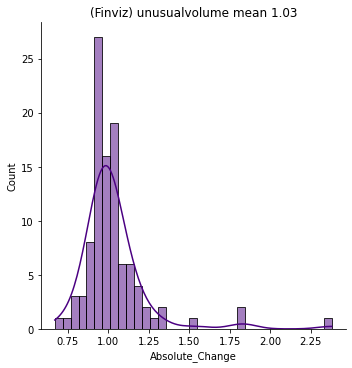

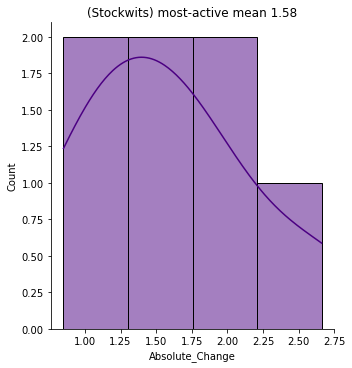

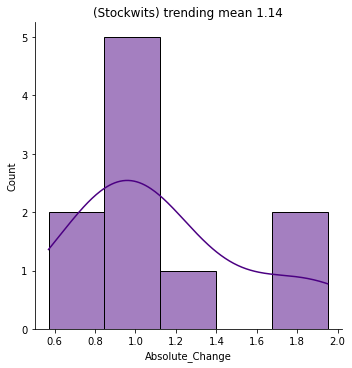

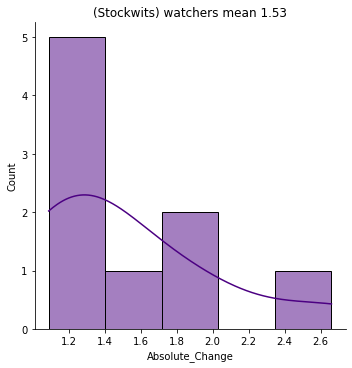

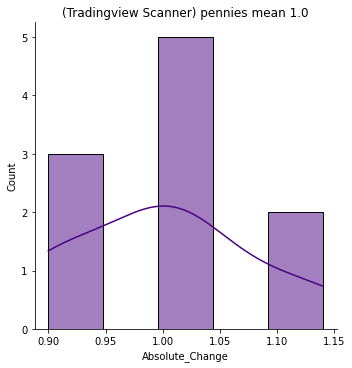

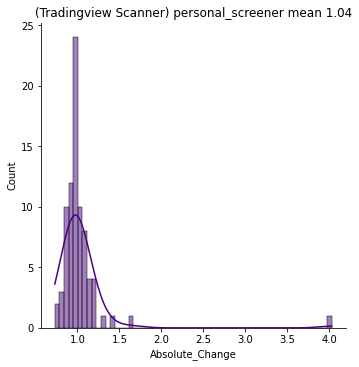

In [278]:
for signal in before.index: 
  sns.displot(x = before_crash[before_crash.Signal == signal].Absolute_Change, kde=True, color = 'indigo')
  plt.title(f'{signal} mean {(before_crash[before_crash.Signal == signal].Absolute_Change.mean()):.3}')

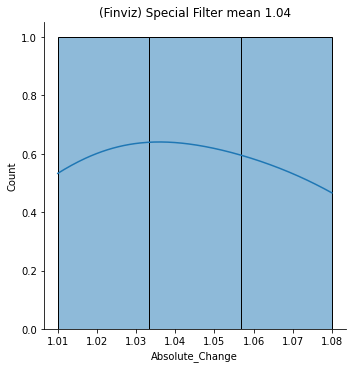

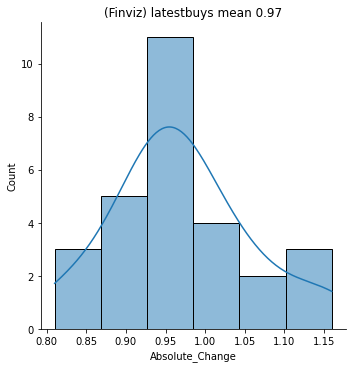

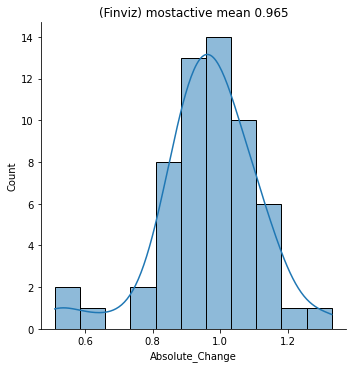

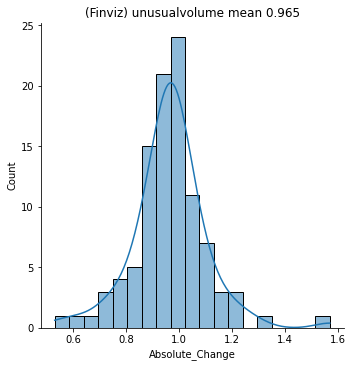

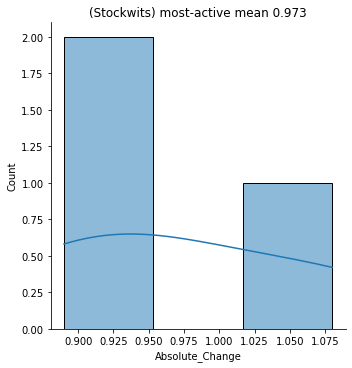

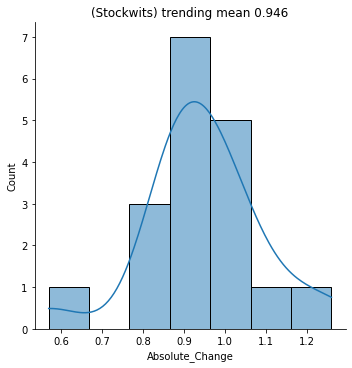

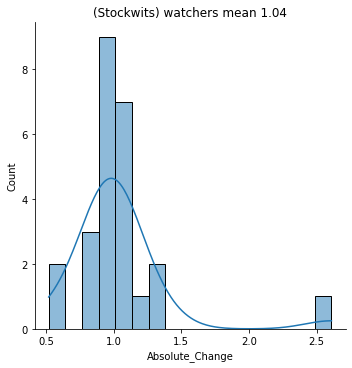

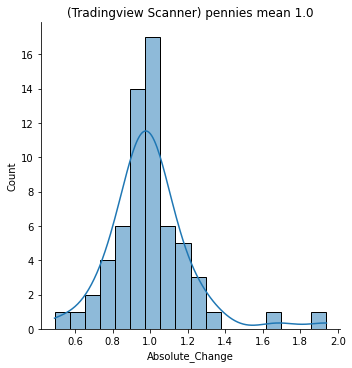

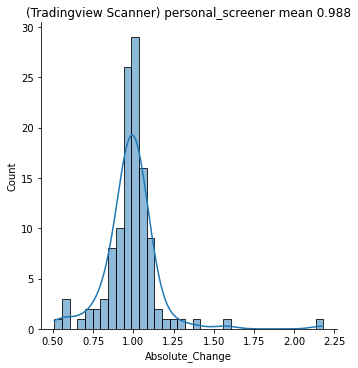

In [279]:
for signal in after.index: 
  sns.displot(x = after_crash[after_crash.Signal == signal].Absolute_Change, kde=True)
  plt.title(f'{signal} mean {(after_crash[after_crash.Signal == signal].Absolute_Change.mean()):.3}')

# More signals = better performance? 

<Figure size 800x300 with 0 Axes>

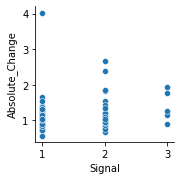

In [303]:
foo = before_crash.groupby('Ticker', as_index=False).agg({'Signal': pd.Series.count, 'Absolute_Change': pd.Series.mean})
sns.pairplot(foo, x_vars=['Signal'], y_vars=['Absolute_Change'])

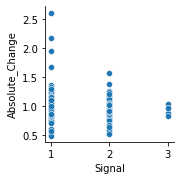

In [304]:
bar = after_crash.groupby('Ticker', as_index=False).agg({'Signal': pd.Series.count, 'Absolute_Change': pd.Series.mean})
sns.pairplot(bar, x_vars=['Signal'], y_vars=['Absolute_Change'])

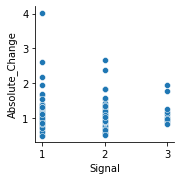

In [305]:
baz = new_df.groupby('Ticker', as_index=False).agg({'Signal': pd.Series.count, 'Absolute_Change': pd.Series.mean})
sns.pairplot(baz, x_vars=['Signal'], y_vars=['Absolute_Change'])

No correlation between number of signals collected and performance (1 = pre-crash, 2 = post-crash and 3=undevided data set)

# Correlation to price? 


In [151]:

fig = px.scatter(before_crash, x = 'Log_Price_Closing_Price_t0', y = 'Absolute_Change', color = 'Sector')
fig.update_layout(title='% Absolute Change vs. Log Price before Crash', yaxis_title='Absolute Change %', xaxis_title='Log Price', yaxis =dict(tickformat = ',.0%'), xaxis =dict(range = [0, 10]))
fig.show()

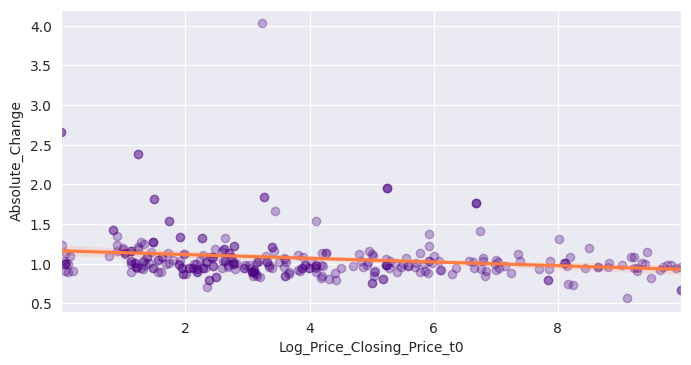

In [173]:
plt.figure(figsize=(8,4), dpi=100)
with sns.axes_style('darkgrid'): 
  sns.regplot(x = before_crash.Log_Price_Closing_Price_t0, y = before_crash.Absolute_Change, color='indigo', scatter_kws={'alpha':0.3}, line_kws={'color': '#ff7c43'})

we see a weak correlation,  but maybe the dataset is biased toward lower priced stocks



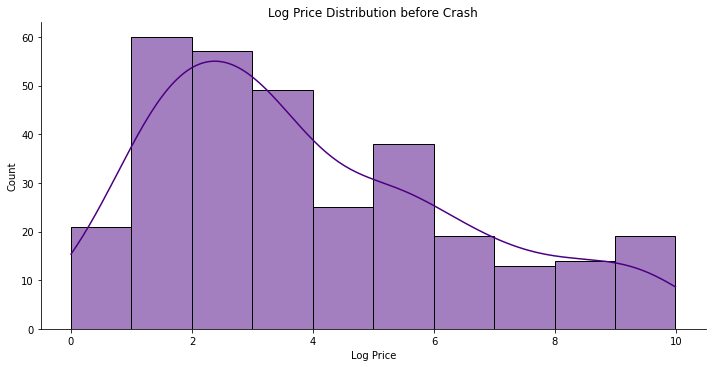

In [161]:
fig = sns.displot(before_crash.Log_Price_Closing_Price_t0, color = 'indigo', aspect = 2, kde=True)
fig.set(xlabel='Log Price', title='Log Price Distribution before Crash')

yup, dataset is biased

In [148]:
fig = px.scatter(after_crash, x = 'Log_Price_Closing_Price_t0', y = 'Absolute_Change', color = 'Sector')
fig.update_layout(title='% Absolute Change vs. Log Price after Crash', yaxis_title='Absolute Change %', xaxis_title='Log Price', yaxis =dict(tickformat = ',.0%'), xaxis =dict(range = [0, 10]))
fig.show()

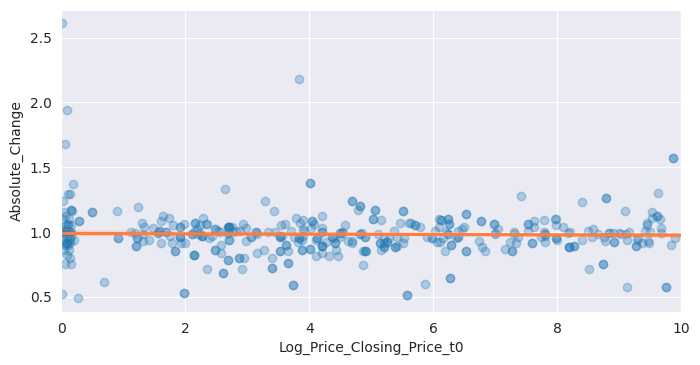

In [176]:
plt.figure(figsize=(8,4), dpi=100)
with sns.axes_style('darkgrid'): 
  fig = sns.regplot(x = after_crash.Log_Price_Closing_Price_t0, y = after_crash.Absolute_Change, scatter_kws={'alpha':0.3}, line_kws={'color': '#ff7c43'})
  fig.set(xlim=(0,10))

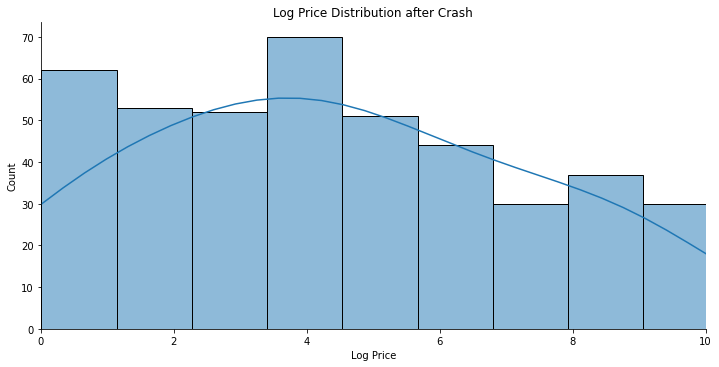

In [164]:
fig = sns.displot(after_crash.Log_Price_Closing_Price_t0,aspect = 2, kde=True,)
fig.set(xlabel='Log Price', title='Log Price Distribution after Crash', xlim=(0,10))

>>> apparently no strong correlation (i.e. none after crash) between stock price and performance, some outliers are visible in before and after crash scatter plots. however, at least in the before crash plot, these might be due to the unequal distribution of  log prices in the data set
